In [1]:
import magfli as mf
import numpy as np
import matplotlib.pyplot as plt
import swmfio as swmfio

In this journal, we perform a visual validation of the field tracing algorithm.  We trace a field line for a magnetic field from a Space Weather Model Framework (SWMF) run.  We plot a field line that has curvature, and overlay the field line with unit vector arrows (quiver plot) in the director of the magnetic field at points along the trace.  The unit vectors should be tangent to the field line.  And since the field line is in the northern hemisphere, the arrow (which are small) should be pointing down.  As seen below, both are true.

In [2]:
# Pull in the data from the SWMF file

# Location of SWMF file
tmpdir = '/Volumes/Physics HD/runs/DIPTSUR2/GM/IO2/'
filebase = '3d__var_2_e20190902-041400-000'

# Read file contents
batsclass = swmfio.read_batsrus(tmpdir + filebase)

# Get x, y, z and Bx, By, Bz from contents
var_dict = dict(batsclass.varidx)
X = batsclass.data_arr[:,var_dict['x']][:]
Y = batsclass.data_arr[:,var_dict['y']][:]
Z = batsclass.data_arr[:,var_dict['z']][:]

Bx = batsclass.data_arr[:,var_dict['bx']][:]
By = batsclass.data_arr[:,var_dict['by']][:]
Bz = batsclass.data_arr[:,var_dict['bz']][:]


In [3]:
# Set up the process for tracing a field line.

# Determine the box bounding the domain for solution
# We use trace_stop_earth_box that considers whether the trace is outside the earth 
# and inside of the box.
Xmin = [min(X), min(Y), min(Z)]
Xmax = [max(X), max(Y), max(Z)]

# Setup multitrace for tracing field lines 
mt = mf.multitrace_cartesian_unstructured( X, Y, Z, Bx, By, Bz,
                               Stop_Function = mf.trace_stop_earth_box, 
                               tol = 1e-4, grid_spacing = 1, max_length = 500, 
                               method_ode = 'RK23', method_interp = 'nearest' )

# Examine a field trace with curvature
# Field line starts at the earth's surface at colatitude and longitude specified below
col = np.deg2rad(10)  
long = np.deg2rad(140)

# Convert start point to cartesian coordinates
X0 = [ np.cos(long)*np.sin(col), np.sin(long)*np.sin(col), np.cos(col) ]

# Trace field line
field_line = mt.trace_field_line( X0, False )

# Determine B field at points along the field line.
# Normalize B vectors to unit vectors
B_field = np.empty((0,3), float)
shape = np.shape(field_line)
for i in range(shape[1]): 
    X = [ field_line[0,i], field_line[1,i], field_line[2,i] ]
    B = mt.trace_magnetic_field(X)
    B_mag = np.linalg.norm(B)
    B = B/B_mag
    B_field = np.append(B_field, np.array([[B[0], B[1], B[2]]]), axis=0)

multitrace.py:__init__(): Initializing multitrace for unstructured data: 0.0001 1 500 RK23 nearest
multitrace.py:trace_field_line(): Tracing field line...[-0.13302222155948898, 0.11161889704894967, 0.984807753012208]


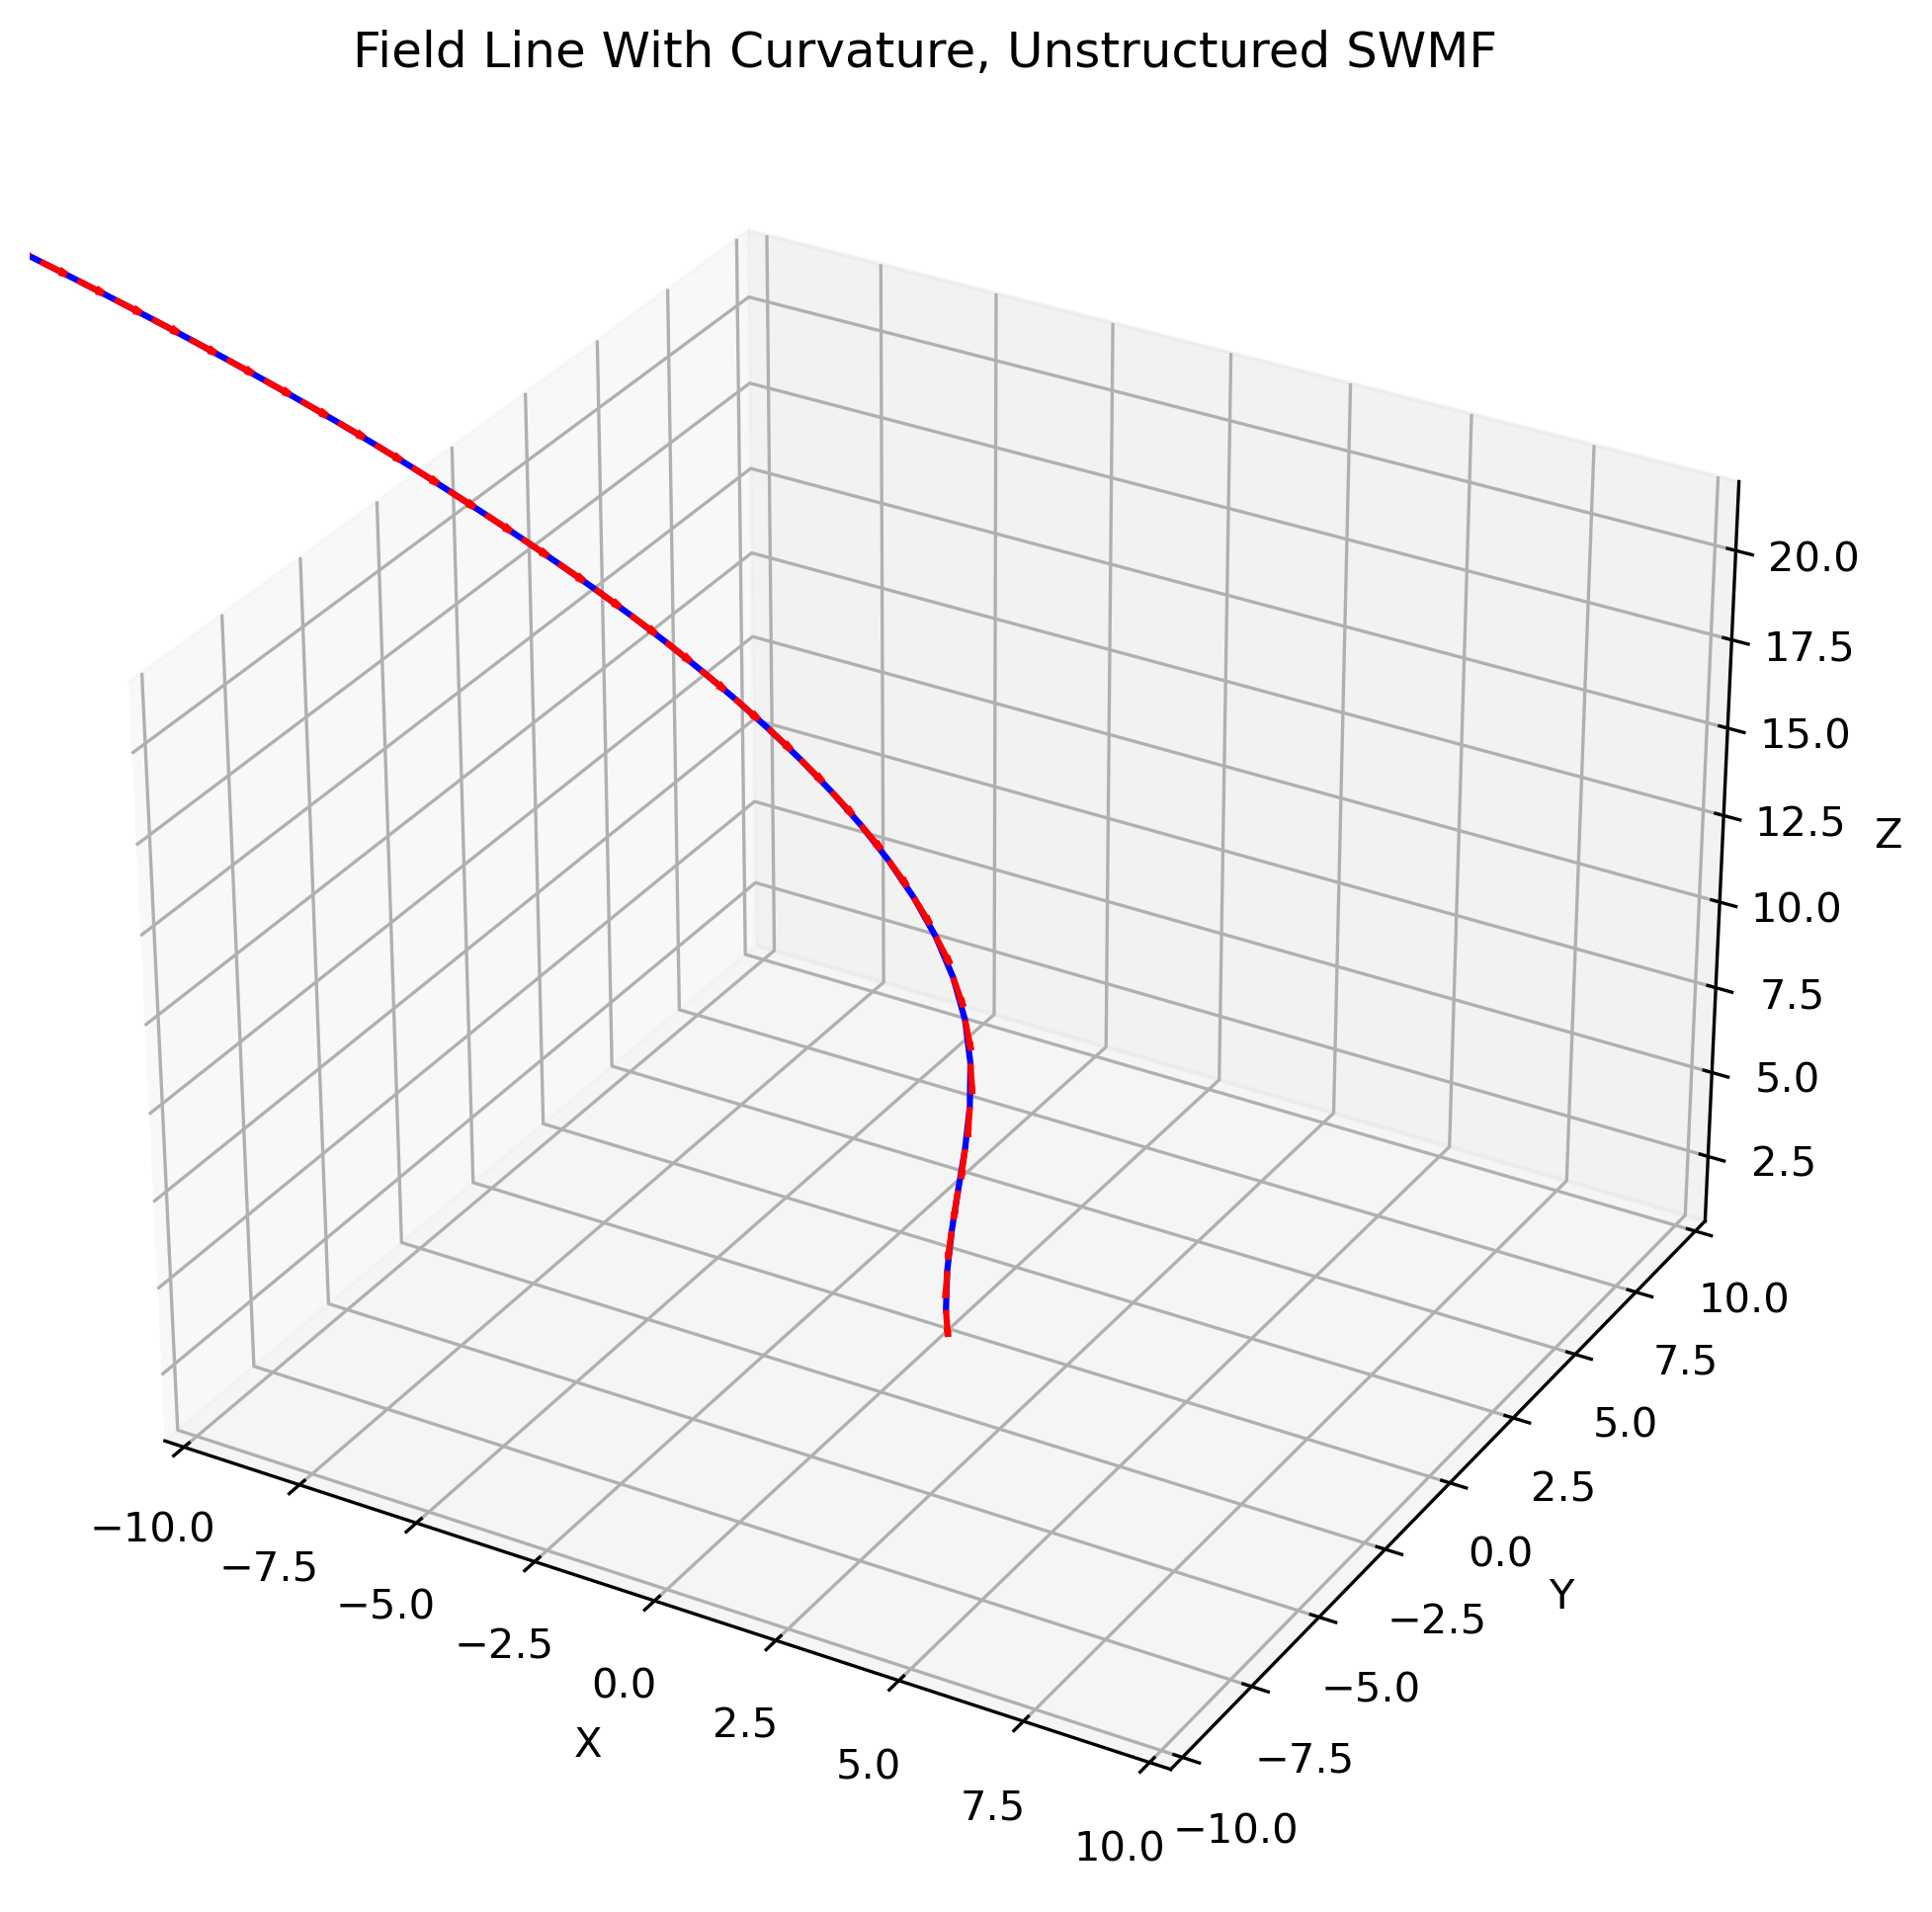

In [4]:
# Setup plot for field line
fig = plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection='3d')
ax.set_title('Field Line With Curvature, Unstructured SWMF')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Focus plot on region with curvature
xmin = min(field_line[0,:])
xmax = max(field_line[0,:])
ymin = min(field_line[1,:])
ymax = max(field_line[1,:])
zmin = min(field_line[2,:])
zmax = max(field_line[2,:])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

# Plot field line
ax.plot( field_line[0,:], field_line[1,:], field_line[2,:], color='blue' )

# Plot B unit vectors on field line
ax.quiver(field_line[0,:], field_line[1,:], field_line[2,:], B_field[:,0], B_field[:,1], B_field[:,2], 
          length=0.7, color='red')